In [107]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/dogImages/train')
valid_files, valid_targets = load_dataset('data/dogImages/valid')
test_files, test_targets = load_dataset('data/dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("data/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [108]:
from keras.applications import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [109]:
import keras.utils as image                 
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [110]:
from keras.applications.resnet import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [111]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [112]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet = bottleneck_features['train']
valid_Resnet = bottleneck_features['valid']
test_Resnet = bottleneck_features['test']

In [113]:
Resnet_Model = Sequential()

Resnet_Model.add(GlobalAveragePooling2D(input_shape=train_Resnet.shape[1:]))
Resnet_Model.add(Dense(133,activation='softmax'))

Resnet_Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [114]:
Resnet_Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [116]:
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet.hdf5', 
                               verbose=1, save_best_only=True)

Resnet_Model.fit(train_Resnet, train_targets, 
          validation_data=(valid_Resnet, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
308/334 [==========================>...] - ETA: 0s - loss: 0.0084 - accuracy: 0.9981
Epoch 1: val_loss improved from inf to 0.79529, saving model to saved_models/weights.best.Resnet.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 0.0088 - accuracy: 0.9978 - val_loss: 0.7953 - val_accuracy: 0.8144
Epoch 2/20
333/334 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9977
Epoch 2: val_loss did not improve from 0.79529
334/334 [==============================] - 0s 1ms/step - loss: 0.0129 - accuracy: 0.9978 - val_loss: 0.8112 - val_accuracy: 0.8132
Epoch 3/20
283/334 [========================>.....] - ETA: 0s - loss: 0.0114 - accuracy: 0.9966
Epoch 3: val_loss improved from 0.79529 to 0.77273, saving model to saved_models/weights.best.Resnet.hdf5
334/334 [==============================] - 0s 1ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.7727 - val_accuracy: 0.8192
Epoch 4/20
279/334 [========================>.....] - ETA: 0s - 

In [117]:
path = '/Users/bivanshrestha/Desktop/Dog Classification Websie/model_creation/saved-model/acc_0.8216_Resnet_model.h5'
Resnet_Model.save(path)

In [81]:
Resnet_Predictions = [np.argmax(Resnet_Model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet]

# Reporting Test Accuracy
test_accuracy = 100*np.sum(np.array(Resnet_Predictions)==np.argmax(test_targets, axis=1))/len(Resnet_Predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Test accuracy: 79.9043%


In [83]:
def extract_Resnet50(tensor):
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def Resnet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet_Model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [104]:
def show_img(img_path):
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = plt.imshow(cv_rgb)
    return img_display

def predict_image(img_path):
    show_img(img_path)
    predicted_breed=Resnet_predict_breed(img_path).rsplit('.',1)[1].replace("_", " ")
    return "The predicted dog breed the "+ str(predicted_breed) + "."

1/1 [==============================] - 0s 10ms/step


'The predicted dog breed the Pembroke welsh corgi.'

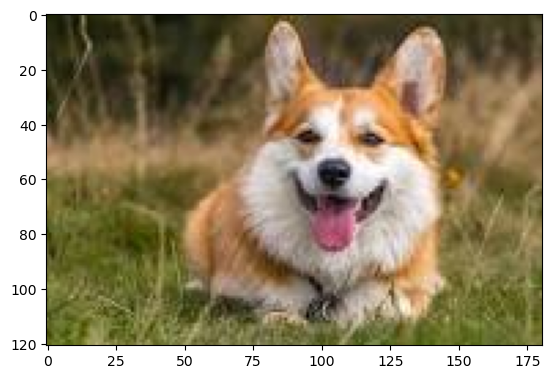

In [105]:
predict_image('Testing-user-images/corgi_test.jpeg')

In [58]:
path = '/Users/bivanshrestha/Desktop/Dog Classification Websie/saved-model/full-model.h5'
from keras.models import load_model
savedModel = load_model(path)
savedModel.summary()

OSError: No file or directory found at /Users/bivanshrestha/Desktop/Dog Classification Websie/saved-model/full-model.h5

In [63]:
path = '/Users/bivanshrestha/Desktop/Dog Classification Websie/saved-model/model.h5'
Resnet_Model.save(path)

In [100]:
Resnet_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 133)               272517    
                                                                 
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________
